In [ ]:
# Codificación NRZ para simular transmisión NRZ-L

def string_to_bits(message: str) -> str:
    """Convierte texto a cadena de bits (8 bits por carácter)."""
    return ''.join(format(ord(c), '08b') for c in message)

def nrz_encode(bits: str, v_high=1.0, v_low=-1.0):
    """
    Codifica la secuencia binaria usando NRZ-L (Level).
    - '1' -> v_high
    - '0' -> v_low
    """
    return [v_high if b == '1' else v_low for b in bits]

def transmit_signal(levels):
    """“Transmite” imprimiendo los niveles (solo a modo ilustrativo)."""
    print(' '.join(f'{lvl:g}' for lvl in levels))

# Ejemplo de uso
message = "Hola"
bits = string_to_bits(message)
print(f"Mensaje: {message}")
print(f"Bits:     {bits}")

# Opción 1 (educativa, bipolar): +1 / -1
nrz_levels = nrz_encode(bits, v_high=1.0, v_low=-1.0)

# Opción 2 (TTL/CMOS): 3.3 V / 0 V  -> descomentar si querés esa visual
# nrz_levels = nrz_encode(bits, v_high=3.3, v_low=0.0)

print("Señal codificada (NRZ-L):")
transmit_signal(nrz_levels)

Mensaje: Hola
Bits:     01001000011011110110110001100001
Señal codificada (NRZ-L):
-1 1 -1 -1 1 -1 -1 -1 -1 1 1 -1 1 1 1 1 -1 1 1 -1 1 1 -1 -1 -1 1 1 -1 -1 -1 -1 1


Bits originales:       [1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0]
Símbolos PAM5 (1D):    [ 1.  2. -2.  1.  1. -1.  2. -2.]
Símbolos + ruido:      [ 1.09  1.96 -2.05  0.9   1.1  -1.07  1.87 -2.07]
Cuantizados a PAM5:    [ 1.  2. -2.  1.  1. -1.  2. -2.]
Bits decodificados:    [1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0]

Streams por par (4D, round-robin):
Par A: [1. 1.]
Par B: [ 2. -1.]
Par C: [-2.  2.]
Par D: [ 1. -2.]


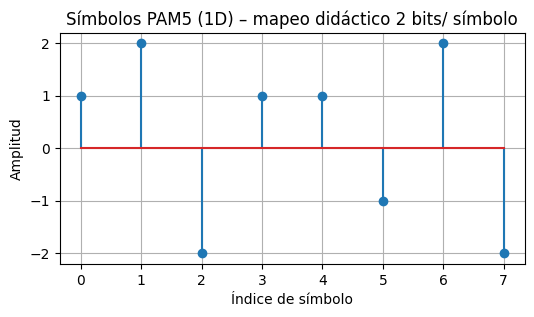

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ===== PAM5: niveles (5) =====
PAM5_LEVELS = np.array([-2, -1, 0, 1, 2], dtype=float)

# ===== Mapeo didáctico (2 bits -> 4 niveles; 0 queda reservado) =====
# 00 -> -2, 01 -> -1, 10 -> +1, 11 -> +2
ENC_MAP = {
    (0, 0): -2.0,
    (0, 1): -1.0,
    (1, 0): +1.0,
    (1, 1): +2.0,
}
DEC_MAP = {v: k for k, v in ENC_MAP.items()}  # inverso exacto

def encode_pam5_2bits_per_symbol(bitstream):
    """Agrupa bits de a 2 y mapea a niveles PAM5 (usando 4 de los 5 niveles)."""
    if len(bitstream) % 2 != 0:
        raise ValueError("La longitud de bits debe ser par.")
    symbols = []
    for i in range(0, len(bitstream), 2):
        pair = (int(bitstream[i]), int(bitstream[i+1]))
        symbols.append(ENC_MAP[pair])
    return np.array(symbols, dtype=float)

def quantize_to_pam5(x):
    """Cuantiza al vecino PAM5 más cercano (tolerante a ruido)."""
    idx = np.abs(PAM5_LEVELS.reshape(-1, 1) - x.reshape(1, -1)).argmin(axis=0)
    return PAM5_LEVELS[idx]

def decode_pam5_2bits_per_symbol(symbols):
    """Decodifica asumiendo mapeo de 4 niveles; si aparece 0, lo marca como 'reserva'."""
    bits = []
    for s in symbols:
        s_q = PAM5_LEVELS[np.argmin(np.abs(PAM5_LEVELS - s))]  # cuantización
        if s_q == 0.0:
            # Nivel reservado en este esquema didáctico
            # Podrías decidir descartarlo o mapearlo a (0,0) con una advertencia.
            raise ValueError("Apareció nivel 0 (reservado) en esta codificación simplificada.")
        b0, b1 = DEC_MAP[s_q]
        bits.extend([b0, b1])
    return np.array(bits, dtype=int)

# ===== Reparto 4D (ilustrativo) =====
def split_to_4d_round_robin(symbols):
    """Distribuye símbolos a 4 pares A,B,C,D en round-robin (ilustración 4D)."""
    A = symbols[0::4]
    B = symbols[1::4]
    C = symbols[2::4]
    D = symbols[3::4]
    return A, B, C, D

def merge_from_4d_round_robin(A, B, C, D):
    """Reconstruye la secuencia 1D desde 4 streams round-robin."""
    L = max(len(A), len(B), len(C), len(D))
    out = []
    for i in range(L):
        if i < len(A): out.append(A[i])
        if i < len(B): out.append(B[i])
        if i < len(C): out.append(C[i])
        if i < len(D): out.append(D[i])
    return np.array(out, dtype=float)

# ===== Ejemplo =====
original_bits = np.array([1,0, 1,1, 0,0, 1,0,  1,0, 0,1, 1,1, 0,0])  # 16 bits (8 símbolos)
symbols_1d   = encode_pam5_2bits_per_symbol(original_bits)

# Simular “ruido” leve en el dominio 1D (solo para mostrar la cuantización)
noisy = symbols_1d + 0.1*np.random.randn(*symbols_1d.shape)

# Cuantización y decodificación
symbols_1d_q = quantize_to_pam5(noisy)
decoded_bits = decode_pam5_2bits_per_symbol(symbols_1d_q)

print("Bits originales:      ", original_bits)
print("Símbolos PAM5 (1D):   ", symbols_1d)
print("Símbolos + ruido:     ", noisy.round(2))
print("Cuantizados a PAM5:   ", symbols_1d_q)
print("Bits decodificados:   ", decoded_bits)

# Ilustración 4D (reparto a 4 pares)
A, B, C, D = split_to_4d_round_robin(symbols_1d)
print("\nStreams por par (4D, round-robin):")
print("Par A:", A)
print("Par B:", B)
print("Par C:", C)
print("Par D:", D)

# Gráfica simple de los símbolos 1D
plt.figure(figsize=(6,3))
markerline, stemlines, baseline = plt.stem(range(len(symbols_1d)), symbols_1d)
plt.title("Símbolos PAM5 (1D) – mapeo didáctico 2 bits/ símbolo")
plt.xlabel("Índice de símbolo")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

#Ejercicio 17:
1- Simular la transmisión de un mensaje entre dos computadoras.

2- Elegir un protocolo de la pila TCP/IP.

3- Utilizar Gigabit Ethernet sobre UTP con 4D-PAM5.

4- Incluir el uso de un filtro sinc con caída cosenoidal.

#Transmisor:

In [ ]:
# tx_pam5.py
import socket
import numpy as np

# PAM5 modulación: convierte caracteres en niveles -2 a 2
def pam5_modulate(data):
    return [(ord(c) % 5) - 2 for c in data]

# Divide el mensaje en 4 canales
def split_into_channels(message):
    return [message[i::4] for i in range(4)]

# Configuración del socket
HOST = 10.0.0.209  # Reemplazar con la IP del RX
PORT = 5000

message = "Hola Leandro, esto es una prueba de 4D-PAM5"
channels = split_into_channels(message)
modulated_channels = [pam5_modulate(ch) for ch in channels]

# Empaquetar los datos como string
packet = '|'.join([','.join(map(str, ch)) for ch in modulated_channels])

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.connect((HOST, PORT))
    s.sendall(packet.encode('utf-8'))
    print("Mensaje enviado.")

#Receptor:

In [ ]:
# rx_pam5.py
import socket

# PAM5 demodulación: convierte niveles -2 a 2 en caracteres aproximados
def pam5_demodulate(data):
    return ''.join([chr((int(val) + 2) % 256) for val in data])

# Reconstruye el mensaje original desde los 4 canales
def reconstruct_message(channels):
    max_len = max(len(ch) for ch in channels)
    message = ''
    for i in range(max_len):
        for ch in channels:
            if i < len(ch):
                message += ch[i]
    return message

HOST = '0.0.0.0'
PORT = 5000

with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
    s.bind((HOST, PORT))
    s.listen()
    print("Esperando conexión...")
    conn, addr = s.accept()
    with conn:
        print(f"Conectado por {addr}")
        data = conn.recv(4096).decode('utf-8')
        raw_channels = data.split('|')
        channels = [pam5_demodulate(ch.split(',')) for ch in raw_channels]
        message = reconstruct_message(channels)
        print("Mensaje recibido y reconstruido:")
        print(message)